In [218]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching import results_path
from conditional_rate_matching.models.pipelines.sdes_samplers.samplers import TauLeaping

from conditional_rate_matching.configs.experiments_configs.crm.crm_experiments_graph import experiment_comunity_small

from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import (ConstantThermostatConfig, 
                                                                                         PeriodicThermostatConfig,
                                                                                         ExponentialThermostatConfig,
                                                                                         PolynomialThermostatConfig,
                                                                                         PlateauThermostatConfig
                                                                                         )
def generate_graph_samples(path,
                           num_timesteps=100,
                           time_epsilon=0.005, 
                           device="cpu"):

    crm = CRM(experiment_dir=path, device=device)
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = num_timesteps
    crm.config.pipeline.number_of_steps = num_timesteps

    source = crm.dataloader_0.test()
    target = crm.dataloader_1.test()

    x_1, x_0, x_test = [], [], []

    for batch in target:
        test_images = batch[0]
        x_test.append(test_images)
    
    for batch in source:
        input_graphs = batch[0]
        gen_graphs = crm.pipeline(sample_size=input_graphs.shape[0], return_intermediaries=False, train=False, x_0=input_graphs.to(crm.device))
        x_0.append(input_graphs)
        x_1.append(gen_graphs.detach().cpu())

    x_test = torch.cat(x_test)
    x_0 = torch.cat(x_0)
    x_1 = torch.cat(x_1)

    N = int(np.sqrt(x_0.shape[-1]))
    x_0 = x_0.view(-1, N, N)
    x_1 = x_1.view(-1, N, N)
                   
    torch.save(x_0, os.path.join(path, "sample_gen_x0.dat"))      
    torch.save(x_1, os.path.join(path, "sample_gen_x1.dat"))      
    torch.save(x_test, os.path.join(path, "sample_gen_test.dat"))
    
    return x_0, x_1, x_test

def generate_samples(path, 
                     x_test,
                     num_timesteps=100, 
                     time_epsilon=0.0,
                     device="cpu"):
    
    crm = CRM(experiment_dir=path, device=device)
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = num_timesteps
    crm.config.pipeline.number_of_steps = num_timesteps

    x_1, x_t, t = crm.pipeline(x_test.shape[0], 
                               return_intermediaries=True, 
                               train=False, 
                               x_0=x_test)
    
    return x_1, x_t, t



import networkx as nx
import matplotlib.pyplot as plt

def graph_grid(sample, save_path='.', nrow=1, node_size=10, edge_width=2, node_color="darkred", edge_color="gray", figsize=(4, 4)):
    num_img = sample.shape[0]    
    ncol = math.ceil(num_img / nrow)
    _, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    
    for i in range(num_img):
        adj_matrix = sample[i].numpy()
        G = nx.from_numpy_array(adj_matrix)
        singleton_nodes = list(nx.isolates(G))
        G.remove_nodes_from(singleton_nodes)
        pos = nx.spring_layout(G, seed=1234)
        nx.draw(G, pos, ax=axes[i], node_size=node_size, width=edge_width, node_color=node_color, edge_color=edge_color, with_labels=False)

    for j in range(num_img, nrow * ncol):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(save_path+'/selected_sample.png')
    plt.show()



source data:

In [224]:
path = "../../results/crm/graphs/noise_to_community_gnn_uniform_coupling_ConstantThermostat_gamma_1.0__16h49s17_2024.05.17__run"
device = "cuda:1"

g0, g1, gtest =  generate_graph_samples(path,
                                    num_timesteps=1000,
                                    time_epsilon=0.005, 
                                    device=device)

1000it [00:03, 259.39it/s]
1000it [00:03, 260.28it/s]


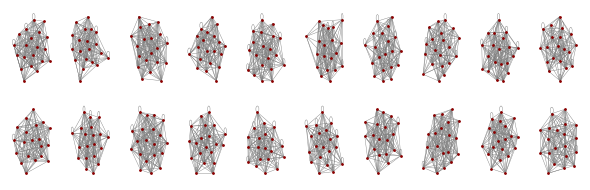

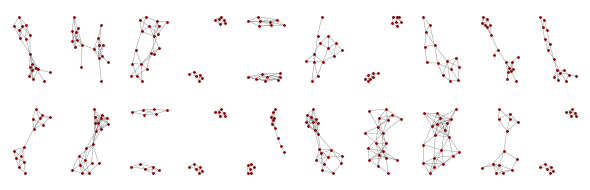

In [225]:
graph_grid(g0[:100], nrow=2, node_size=1, edge_width=0.3, figsize=(6, 2))
graph_grid(g1[:100], nrow=2, node_size=1, edge_width=0.3, figsize=(6, 2))

target data:

In [227]:

def configure_thermostat(config, thermostat, params):
    thermostat_config_classes = {
        'exponential': ExponentialThermostatConfig,
        'constant': ConstantThermostatConfig,
        'periodic': PeriodicThermostatConfig,
        'polynomial': PolynomialThermostatConfig,
        'plateau': PlateauThermostatConfig
    }
    
    thermostat_config = thermostat_config_classes[thermostat]()
    gamma, *other_params = params
    thermostat_config.gamma = gamma

    if hasattr(thermostat_config, 'max'):
        thermostat_config.max = other_params[0]
    if hasattr(thermostat_config, 'exponent'):
        thermostat_config.exponent = other_params[1]
    if hasattr(thermostat_config, 'slope'):
        thermostat_config.slope = other_params[1]
    if hasattr(thermostat_config, 'shift'):
        thermostat_config.shift = other_params[2]

    config.thermostat = thermostat_config



def graph_conditional_bridge(source, 
                             target, 
                             thermostat="constant", 
                             thermostat_params=(.1,0),
                             figsize=None, 
                             num_timesteps=100,
                             num_timesteps_displayed=10,
                             save_path=None):
    
    config = experiment_comunity_small(network="simple")
    
    if thermostat == 'exponential':
        config.thermostat = ExponentialThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.max = thermostat_params[1]
    elif thermostat == 'constant':
        config.thermostat = ConstantThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
    elif thermostat == 'periodic':
        config.thermostat = PeriodicThermostatConfig()
        config.thermostat.gamma= thermostat_params[0]
        config.thermostat.max = thermostat_params[1]
    elif thermostat == 'polynomial':
        config.thermostat = PolynomialThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.exponent = thermostat_params[1]
    elif thermostat == 'plateau':
        config.thermostat = PlateauThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.slope = thermostat_params[1]
        config.thermostat.shift = thermostat_params[2]

    crm = CRM(config)
    crm.config.pipeline.number_of_steps = num_timesteps
    crm.config.pipeline.num_intermediates = num_timesteps_displayed

    num_grph, N, _ = source.shape

    print("dim adj = ", N)

    rate_model = lambda x, t: crm.forward_rate.conditional_transition_rate(x, target.view(-1,  N * N), t)
    gph_1, gph_hist, _ , time = TauLeaping(crm.config, rate_model, source.view(-1, N * N), forward=True)
    gph_1 = gph_1.long().view(-1,  N, N)
    gph_hist = gph_hist.long().view(-1, gph_hist.shape[1], N, N)
    path = torch.cat( [gph_hist , gph_1.unsqueeze(1)], dim=1)

    for i in range(num_grph):
        graph_grid(path[i], nrow=1, node_size=2, edge_width=0.3, figsize=figsize)


    return gph_1, gph_hist, time


# Markov interpolators

In [212]:
g0[:4].shape

torch.Size([4, 17, 17])

dim adj =  20


100it [00:00, 1040.45it/s]


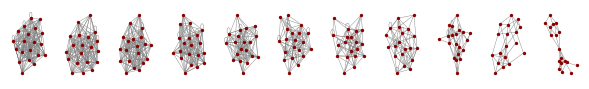

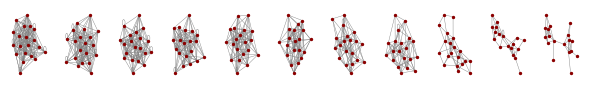

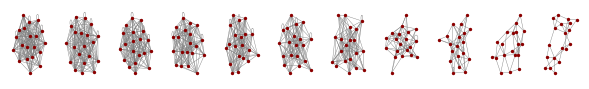

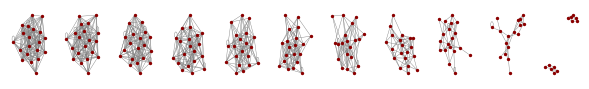

In [230]:
g_1_, g_path, t =  graph_conditional_bridge(g0[:4], g1[:4], thermostat="constant",  figsize=(6,1), thermostat_params=(1e-4, 0.0), num_timesteps=100, num_timesteps_displayed=10)


## Generated images from CRM

In [ ]:
path = "crm_cifar10_gamma_0.01"
noise = get_cifar10_test_samples(path, which='source', sample_size=16, device="cuda:0")
image_grid(noise, nrow=4, num_img=16, figsize=(3,3))

In [ ]:
path = "crm_cifar10_gamma_0.01"
samples,_ , _ = generate_samples(path, noise, num_timesteps=100, time_epsilon=0.0, device="cuda:0")
image_grid(samples, num_img=16, nrow=4, figsize=(3,3))

In [ ]:
cifar_noise_bridge(path, 
                x_input=noise, 
                num_timesteps=100,  
                time_epsilon=0.,
                num_img=5,
                num_timesteps_displayed=20,
                save_path=None)